In [1]:
from io import open
import glob
import os
import unicodedata
import string

In [2]:
all_letters=string.ascii_letters+" .,;'-"
n_letters=len(all_letters)+1 #plus EOS marker

def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) 
                          if unicodedata.category(c)!='Mn' and c in all_letters)
def readLines(filename):
    lines=open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
category_lines={}
all_categories=[]
for filename in findFiles('data/data/names/*.txt'):
    category=os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines=readLines(filename)
    category_lines[category]=lines
n_categories=len(all_categories)

if n_categories==0:
    raise RuntimeError('data not found')
print('# categories:',n_categories,all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [3]:
import torch
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size=hidden_size
        self.i2h=nn.Linear(n_categories+input_size+hidden_size,hidden_size)
        self.i2o=nn.Linear(n_categories+input_size+hidden_size,output_size)
        self.o2o=nn.Linear(hidden_size+output_size,output_size)
        self.dropout=nn.Dropout(0.1)
        self.softmax=nn.LogSoftmax(dim=1)
        
    def forward(self,category,input,hidden):
        input_combined=torch.cat((category,input,hidden),1)
        hidden=self.i2h(input_combined)
        output=self.i2o(input_combined)
        output_combined=torch.cat((hidden,output),1)
        output=self.o2o(output_combined)
        output=self.dropout(output)
        output=self.softmax(output)
        return output,hidden
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

In [4]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]
def randomTrainingPair():
    category=randomChoice(all_categories)
    line=randomChoice(category_lines[category])
    return category,line
def categoryTensor(category):
    li=all_categories.index(category)
    tensor=torch.zeros(1,n_categories)
    tensor[0][li]=1
    return tensor

def inputTensor(line):
    tensor=torch.zeros(len(line),1,n_letters)
    for li in range(len(line)):
        letter=line[li]
        tensor[li][0][all_letters.find(letter)]=1
    return tensor
def targetTensor(line):
    letter_indexes=[all_letters.find(line[li]) for li in range(1,len(line))]
    letter_indexes.append(n_letters-1) #EOS
    return torch.LongTensor(letter_indexes)


In [5]:
print(targetTensor('abc'))

tensor([ 1,  2, 58])


In [6]:
def randomTrainingExample():
    category,line=randomTrainingPair()
    category_tensor=categoryTensor(category)
    input_line_tensor=inputTensor(line)
    target_line_tensor=targetTensor(line)
    return category_tensor,input_line_tensor,target_line_tensor


In [21]:
#Train
criterion=nn.NLLLoss()
learning_rate=0.0005
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(category_tensor,input_line_tensor,target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden=rnn.initHidden()
    rnn.zero_grad()
    loss=0
    for i in range(input_line_tensor.size(0)):
        output,hidden=rnn(category_tensor.to(device),input_line_tensor[i].to(device),hidden.to(device))
        l=criterion(output,target_line_tensor[i].to(device))
        loss+=l
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-learning_rate)
    return output,loss.item()/input_line_tensor.size(0)


In [22]:
import time
import math
def timeSince(since):
    now=time.time()
    s=now-since
    m=math.floor(s/60)
    s-=m*60
    return "%dm %ds"%(m,s)


In [23]:

rnn=RNN(n_letters,128,n_letters).to(device)
n_iters=100000
print_every=5000
plot_every=500
all_losses=[]
total_loss=0
start=time.time()

for iters in range(1,n_iters+1):
    output,loss=train(*randomTrainingExample())
    total_loss+=loss
    if iters % print_every==0:
        print('%s (%d %d%%) %.4f'% (timeSince(start),iters,iters/n_iters*100,loss))
    if iters % plot_every==0:
        all_losses.append(total_loss/plot_every)
        total_loss=0

1m 39s (5000 5%) 3.5180
3m 23s (10000 10%) 2.3243
5m 48s (15000 15%) 2.3282
8m 19s (20000 20%) 2.3675
10m 40s (25000 25%) 2.0250
13m 12s (30000 30%) 2.6070
15m 19s (35000 35%) 2.8199
17m 12s (40000 40%) 2.0038
19m 6s (45000 45%) 2.3571
20m 59s (50000 50%) 2.2871
23m 19s (55000 55%) 2.0629
25m 48s (60000 60%) 2.6077
28m 14s (65000 65%) 3.0388
30m 45s (70000 70%) 2.1565
33m 4s (75000 75%) 2.3175
35m 26s (80000 80%) 1.6692
37m 36s (85000 85%) 2.3728
39m 31s (90000 90%) 2.0457
41m 25s (95000 95%) 2.0310
43m 20s (100000 100%) 2.6164


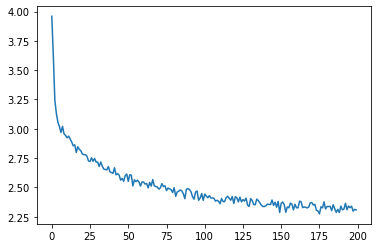

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)
plt.show()

In [30]:
max_length=20
def sample(category,start_letter='A'):
    with torch.no_grad():
        category_tensor=categoryTensor(category)
        input=inputTensor(start_letter)
        hidden=rnn.initHidden()
        
        output_name=start_letter
        for i in range(max_length):
            output,hidden=rnn(category_tensor.to(device),input[0].to(device),hidden.to(device))
            topv,topi=output.topk(1)
            topi=topi[0][0]
            if topi==n_letters-1:
                break
            else:
                letter=all_letters[topi]
                output_name+=letter
            input=inputTensor(letter)
        return output_name
    
def samples(category,start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category,start_letter))
        
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovakovakov
Uoshinokov
Sakinovakov
Gerren
Eres
Roune
Sera
Para
Artana
Cha
Han
Ian
